<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lecture 9: Least Squares Monte Carlo

## Dr P. V. Johnson
## Department of Mathematics

## Least Squares Monte Carlo: Longstaff and Schwartz (2001)

 Monte Carlo methods is a popular choice to calculate the value for most types of options, but they struggle with early exercise. This is the subject of lots of research at the moment and we have seen the basic idea of some of the methods. What we present here is one of the easiest methods to understand and implement. There are still issues with how it performs in practise which we will also deal with here. The key issue is: _How to find what is the expected value for continuation?_ The continuation value is the discounted expected option value at the next instance in time.

The Longstaff and Schwartz method estimates the conditional expected option value by:

- simulating lots of paths
- carrying out a regression analysis on the resulting option values

This gives an approximation for the continuation value that can then be compared to the early exercise value and then we know the option value at each point in time on each path. In terms of Monte Carlo pricing, all we actually need to know is the rule for early exercising, so we know when we receive the 
cash flows and the value of the option is the average of the discounted payoffs for each path.


In [1]:
import numpy
import matplotlib.pyplot as plt

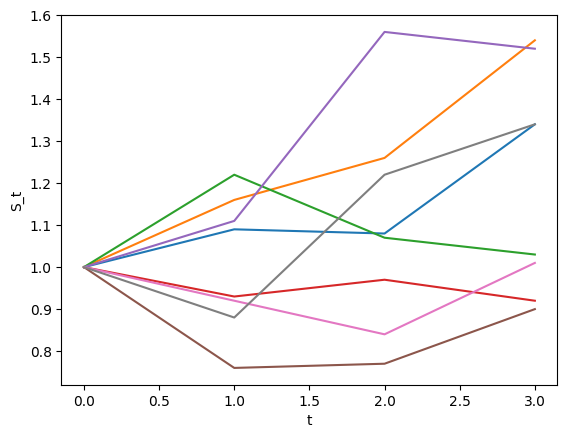

In [2]:
# number of exercise dates
timeSteps=3;
# some parameters in the problem
maturity=3.
interestRate=0.06
strikePrice=1.1
S_0=1.
sigma=0.4
# local parameters
dt=maturity/timeSteps;
# number of paths n
n=8
# degree of fitting polynomial
M_degree=2
# the paths as given in Longstaff & Schartz (2001)
paths = [
            [ 1. , 1.09 , 1.08 , 1.34 ] ,
            [ 1. , 1.16 , 1.26 , 1.54 ] ,
            [ 1. , 1.22 , 1.07 , 1.03 ] ,
            [ 1. , 0.93 , 0.97 , 0.92 ] ,
            [ 1. , 1.11 , 1.56 , 1.52 ] ,
            [ 1. , 0.76 , 0.77 , 0.90 ],
            [ 1. , 0.92 , 0.84 , 1.01 ] ,
            [ 1. , 0.88 , 1.22 , 1.34 ] ,
]

exercisePeriod = numpy.zeros(n,dtype=int)
t = numpy.zeros(timeSteps+1)
for i in range(timeSteps+1):
    t[i] = i*dt

for p in range(n):
    plt.xlabel("t")
    plt.ylabel("S_t")
    plt.plot(t,paths[p])

Each of the 8 paths are plotted. We can see for instance that the light blue line is path number 3 from the paper.

We need to use this information to determine the continuation value at each point in time for each path. To do this we will construct a "Cash Flow Matrix" at each point in time. The table below denotes the cash flows at $t=3$ assuming that we held the option that far:

| Path |  t=1  |  t=2  |  t=3  |
|------|-------|-------|-------|
|1     |     - |     - |   .00 |
|2     | -     | -     | .00   |
|3     | -     | -     | .07   |
|4     | -     | -     | .18   |
|5     | -     | -     | .00   |
|6     |     - | -     | .20   |
|7     |     - | -     | .09   |
|8     |     - | -     | .00   |

At the moment we assume that all the paths are exercised at $t=3$. We need to keep track of when a path is exercised so store this in a vector.

In [3]:
for p in range(n):
    exercisePeriod[p] = timeSteps

The next step is to attempt to find a function that describes the continuation value at time 2 as a function of the value of $S$ at time 2. To do this we use a regression technique, that takes the values at time 2 as the "$x$" values and the discounted payoff at time 3 as the "$y$" values.

| Path |   y                 |  x   |
|------|---------------------|------|
| 1    |   .00 x    0.94176  | 1.08 | 
| 2    | -                   | -    | 
| 3    |  .07 x    0.94176   | 1.07 | 
| 4    |  .18 x    0.94176   |  .97 | 
| 5    | -                   | -    | 
| 6    |  .20  x   0.94176   |  .77 | 
| 7    |  .09 x    0.94176   |  .84 | 
| 8    | -                   | -    | 

We put each of these values into a list, including only values where $S<X$.

In [4]:
# create an empty set of data points
data_x = []
data_y = []

# go through each path, check if it is in the money
# if it is add it as a datapoint with appropriate payoff
for p in range(n):
    if(paths[p][timeSteps-1]<strikePrice):
        data_x.append(paths[p][timeSteps-1])
        data_y.append(max(strikePrice - paths[p][timeSteps],0.)*numpy.exp(-interestRate*dt))

Check the values in `data` match those from the table

In [5]:
print("# Points for fitting")
print("| x_i    | y_i    |")
print("|--------|--------|")
for i in range(len(data_x)):
    print(f"|{data_x[i]:8.2f}|{data_y[i]:8.5f}|")



# Points for fitting
| x_i    | y_i    |
|--------|--------|
|    1.08| 0.00000|
|    1.07| 0.06592|
|    0.97| 0.16952|
|    0.77| 0.18835|
|    0.84| 0.08476|


Use Chebyshev polynomials to fit the data

In [6]:
coeffs = numpy.polynomial.chebyshev.chebfit(data_x, data_y, M_degree)
coeffs

array([-1.97677575,  2.98341063, -0.90678809])

To give you an idea of what this looks like, plot this regression function out against plotted data points. 

In [7]:
cheb_x = numpy.linspace(min(data_x),max(data_x),100)
cheb_y = numpy.zeros(100)
exercise_value = numpy.zeros(100)

for i in range(100):
    cheb_y[i] = numpy.polynomial.chebyshev.chebval(cheb_x[i], coeffs)
    exercise_value[i] = max(strikePrice - cheb_x[i],0.0)

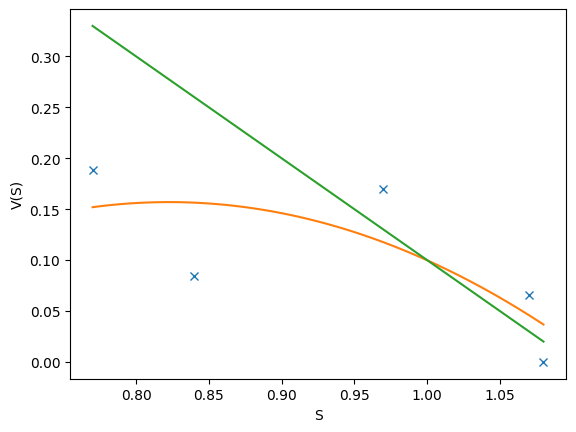

In [8]:
plt.xlabel("S")
plt.ylabel("V(S)")
plt.plot(data_x,data_y,'x')
plt.plot(cheb_x,cheb_y)
plt.plot(cheb_x,exercise_value)

In the figure, the blue crosses show the particular value of continuing along a path, the orange line plots the regression function $V(S,t=2)$, and the green line plots the payoff function $X-S$ we get for exercising early.

This then allows you to decide at which points in time you would exercise and thus determine the cash flows at $t=2$ (below). Notice that for each path, if you exercise at $t=2$ then you do not get to 
also exercise at $t=3$. The decision for a particular path is made by comparing the continuation value vs the exercise value __not__ the future value on that path vs the exercise value. In the picture it infers that any path at $t=2$ with $S<1$ will be exercised early.

In [9]:
print("# Cash flow at this step: ")
print("|     i  |  kstar |      V |")
print("|--------|--------|--------|")
# then select those paths and check against continuation function
for i in range(n):
    
    VS = lambda S: numpy.polynomial.chebyshev.chebval(S,coeffs)

    if paths[i][2]<strikePrice:
        exerciseValue=max(strikePrice - paths[i][2],0.0)
        if exerciseValue > VS(paths[i][2]):
            exercisePeriod[i]=2;
            print(f"|{i+1:8d}|{exercisePeriod[i]:8d}|{strikePrice - paths[i][2]:8.3f}|")
        else: 
            print(f"|{i+1:8d}|{exercisePeriod[i]:8d}|{max(strikePrice - paths[i][3],0.)*numpy.exp(-interestRate*dt):8.3f}|")
    else:
        print(f"|{i+1:8d}|{exercisePeriod[i]:8d}|{max(strikePrice - paths[i][3],0.)*numpy.exp(-interestRate*dt):8.3f}|")

# Cash flow at this step: 
|     i  |  kstar |      V |
|--------|--------|--------|
|       1|       3|   0.000|
|       2|       3|   0.000|
|       3|       3|   0.066|
|       4|       2|   0.130|
|       5|       3|   0.000|
|       6|       2|   0.330|
|       7|       2|   0.260|
|       8|       3|   0.000|


We can apply the same process to $t=1$, for each of the paths that are in the money we regress the discounted future cash flows on the current value of the underlying asset, including any decisions we made to early exercise at $t=2$ in the calculation. We can then form a loop to go through each of the time steps recursively back to the initial start point. Finally the option can be valued by averaging the cash flows on each path.

In [10]:
# number of exercise dates
timeSteps=3
M_degree=2
# some parameters in the problem
maturity=3.
interestRate=0.06
strikePrice=1.1
S_0=1.
# number of paths n
paths=[
            [ 1. , 1.09 , 1.08 , 1.34 ] ,
            [ 1. , 1.16 , 1.26 , 1.54 ] ,
            [ 1. , 1.22 , 1.07 , 1.03 ] ,
            [ 1. , 0.93 , 0.97 , 0.92 ] ,
            [ 1. , 1.11 , 1.56 , 1.52 ] ,
            [ 1. , 0.76 , 0.77 , 0.90 ],
            [ 1. , 0.92 , 0.84 , 1.01 ] ,
            [ 1. , 0.88 , 1.22 , 1.34 ] ,
]
# default exercise period for each path is "timeSteps"
exercisePeriod = numpy.full(n,timeSteps)

# run through time periods back to t=1
for k in range(timeSteps-1,0,-1):
    # create an empty set of data points
    data_x = []
    data_y = []

    # go through each path, check if it is in the money
    # if it is add it as a datapoint with appropriate payoff
    for p in range(n):
        if(paths[p][k]<strikePrice):
            # get current exercise period for this path
            kStar=exercisePeriod[p]
            # calculate time to exercise
            tStar=(kStar-k)*dt
            # add "S" value
            data_x.append(paths[p][k])
            # add "V" value, by discounting value at exercise period
            data_y.append(max(strikePrice - paths[p][kStar],0.)*numpy.exp(-interestRate*tStar))
    
    # generate chebychev fitting polynomial
    coeffs = numpy.polynomial.chebyshev.chebfit(data_x, data_y, M_degree)
    
    # create a function to return the continuation value
    continuationValue = lambda S: numpy.polynomial.chebyshev.chebval(S,coeffs)
        
    print("# Exercise decisions at t=",k*dt,": ")
    print("|     i  |  kstar |");
    print("|--------|--------|");

    # then select those paths and check against continuation function
    for p in range(n):
        # check if path could be exercised early
        if paths[p][k] < strikePrice:
            # get value of exercising early
            exerciseValue=max(strikePrice - paths[p][k],0.)
            # if exercise now value greater than continuation value,
            # then exercise in this period
            if exerciseValue > continuationValue(paths[p][k]):
                exercisePeriod[p]=k
        
        print(f"|{p+1:8d}|{exercisePeriod[p]:8d}|")

# calculate option value using Monte Carlo on the paths
# assume that all paths exercised at t=T to get European value
sum=0.0
for p in range(n):
    # set exercise to final time step for European option
    kStar=timeSteps
    # get exercise value at expiry
    exerciseValue=max(strikePrice - paths[p][kStar],0.0)
    # time until expiry
    exerciseTime=kStar*dt
    # sum up discounted value
    sum+=exerciseValue*numpy.exp(-interestRate*exerciseTime)
print("##\n##\n# European Option Value is ",sum/n,"\n")
    
# calculate American option value using Monte Carlo on the paths
# now we use the optimal exercise decisions calculated above
sum=0.0
for p in range(n):
    # set exercise to final time step for European option
    kStar=exercisePeriod[p]
    # get exercise value at optimal time
    exerciseValue=max(strikePrice - paths[p][kStar],0.0)
    # time until optimal time
    exerciseTime=kStar*dt
    # sum up discounted value
    sum+=exerciseValue*numpy.exp(-interestRate*exerciseTime)
print("##\n##\n# American Option Value is ",sum/n,"\n")

# Exercise decisions at t= 2.0 : 
|     i  |  kstar |
|--------|--------|
|       1|       3|
|       2|       3|
|       3|       3|
|       4|       2|
|       5|       3|
|       6|       2|
|       7|       2|
|       8|       3|
# Exercise decisions at t= 1.0 : 
|     i  |  kstar |
|--------|--------|
|       1|       3|
|       2|       3|
|       3|       3|
|       4|       1|
|       5|       3|
|       6|       1|
|       7|       1|
|       8|       1|
##
##
# European Option Value is  0.05638073927026089 

##
##
# American Option Value is  0.11443433004505696 



So the final value of the option we have for the American style option is 0.114434. If we were to use the exact same paths to value a European style option, we would just exercise all paths at maturity. The corresponding value is found here as 0.0563807, so that the value of the European is less than the value of the American -- which is what we would expect.

Now we just need to put all this in a function. I've split it up so that the path generator is in a different function. Using `numba` to speed things up is highly recommended.

In [14]:
rng = numpy.random.default_rng(seed=0)

def generatePaths(S_0,maturity,interestRate,sigma,timeSteps,n):
    # calculate time step
    dt = maturity/timeSteps
    
    paths=numpy.zeros(shape=(n,timeSteps+1))
    dW = rng.normal( 0.0 , numpy.sqrt(dt) , size = (n,timeSteps) )

    for p in range(n):
        # initialise stock and path variables
        paths[p][0] = S_0
        # run through path
        for k in range(timeSteps):
            paths[p][k+1] = paths[p][k] * numpy.exp((interestRate-0.5*sigma*sigma)*dt+sigma*dW[p][k])
    
    return paths

def monteCarloLeastSquares(S_0,maturity,strikePrice,interestRate,sigma,timeSteps,M_degree,n):
    
    dt = maturity/timeSteps
    
    # number of paths n
    paths=generatePaths(S_0,maturity,interestRate,sigma,timeSteps,n)
    # default exercise period for each path is "timeSteps"
    exercisePeriod = numpy.full(n,timeSteps)

    # run through time periods back to t=1
    for k in range(timeSteps-1,0,-1):
        # create an empty set of data points
        data_x = []
        data_y = []

        # go through each path, check if it is in the money
        # if it is add it as a datapoint with appropriate payoff
        for p in range(n):
            if(paths[p][k]<strikePrice):
                # get current exercise period for this path
                kStar=exercisePeriod[p]
                # calculate time to exercise
                tStar=(kStar-k)*dt
                # add "S" value
                data_x.append(paths[p][k])
                # add "V" value, by discounting value at exercise period
                data_y.append(max(strikePrice - paths[p][kStar],0.)*numpy.exp(-interestRate*tStar))
        
        # check if we have enough data points to do a fit
        if len(data_x) > M_degree+2:
        
            # generate chebychev fitting polynomial
            coeffs = numpy.polynomial.chebyshev.chebfit(data_x, data_y, M_degree)
            
            # create a function to return the continuation value
            continuationValue = lambda S: numpy.polynomial.chebyshev.chebval(S,coeffs)
        # if not just return zero value we can't make a decision on exercise
        else:
            continuationValue = lambda S: 0.0
        
        # uncomment the print statements to see the exercise decisions for each path 
        #print("# Exercise decisions at t=",k*dt,": ")
        #print("|     i  |  kstar |");
        #print("|--------|--------|");

        # then select those paths and check against continuation function
        for p in range(n):
            # check if path could be exercised early
            if paths[p][k] < strikePrice:
                # get value of exercising early
                exerciseValue=max(strikePrice - paths[p][k],0.)
                # if exercise now value greater than continuation value,
                # then exercise in this period
                if exerciseValue > continuationValue(paths[p][k]):
                    exercisePeriod[p]=k
            
        #    print(f"|{p+1:8d}|{exercisePeriod[p]:8d}|")

    # calculate American option value using Monte Carlo on the paths
    # now we use the optimal exercise decisions calculated above
    sum=0.0
    for p in range(n):
        # set exercise to final time step for European option
        kStar=exercisePeriod[p]
        # get exercise value at optimal time
        exerciseValue=max(strikePrice - paths[p][kStar],0.0)
        # time until optimal time
        exerciseTime=kStar*dt
        # sum up discounted value
        sum+=exerciseValue*numpy.exp(-interestRate*exerciseTime)
    return sum/n


Finally we can put this in some code and run some analysis as to what happens as $n\rightarrow\infty$. To analyse the values we might like something to compare against. You can use the calculator on my website [(click here)](https://personalpages.manchester.ac.uk/staff/paul.johnson-2/pages/americanCalculator.html) to get reference values. Choosing $S_0=1.973$, $T=1$, $X=2$, $r=0.05$, $\sigma=0.4$ we have an American option value of $V=0.284$. Running our Monte Carlo code appears to converge on a similar result:-

In [15]:
# number of exercise dates
timeSteps=10
# some parameters in the problem
S_0=1.973
maturity=1.
strikePrice=2.
interestRate=0.05
sigma=0.4
    
# number of paths n
n=1000
# degree of fitting polynomial
M_degree=4

monteCarloLeastSquares(S_0,maturity,strikePrice,interestRate,sigma,timeSteps,M_degree,n)

0.2844989519885668

Running for more simulations takes a long time. Make sure you use `numba` to speed up code if you want to do any analysis, I'm only doing up to 25,000 paths here.

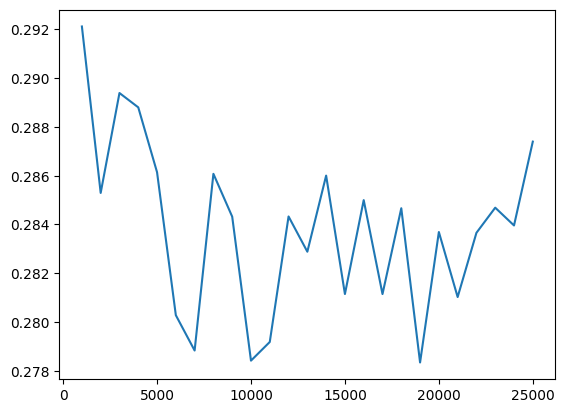

In [13]:

simulations=25
steps = numpy.zeros(simulations)
values = numpy.zeros(simulations)
    
for i in range(simulations):
    N=(i+1)*n
    steps[i] = N
    values[i] = monteCarloLeastSquares(S_0,maturity,strikePrice,interestRate,sigma,timeSteps,M_degree,N)

plt.plot(steps,values)